<a href="https://colab.research.google.com/github/robertaduarte/ai-swiftieversion/blob/main/pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

!gdown 13zMPxc9Wwg5jxj-W162kpqUjpQ8cdlRR

Downloading...
From: https://drive.google.com/uc?id=13zMPxc9Wwg5jxj-W162kpqUjpQ8cdlRR
To: /content/pollution.csv
100% 242k/242k [00:00<00:00, 101MB/s]


In [35]:
df = pd.read_csv("/content/pollution.csv")
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [36]:
def encoding(data, name):

    label = LabelEncoder()
    enc = OneHotEncoder()

    numerical_data = label.fit_transform(data[name])
    #y_data = enc.fit_transform(numerical_data.reshape(-1, 1)).toarray()
    data[name] = list(numerical_data)

    return data

In [37]:
df = encoding(df, 'Air Quality')
df

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,2
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,2
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,2
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,0
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,0
...,...,...,...,...,...,...,...,...,...,...
4995,40.6,74.1,116.0,126.7,45.5,25.7,2.11,2.8,765,1
4996,28.1,96.9,6.9,25.0,25.3,10.8,1.54,5.7,709,2
4997,25.9,78.2,14.2,22.1,34.8,7.8,1.63,9.6,379,2
4998,25.3,44.4,21.4,29.0,23.7,5.7,0.89,11.6,241,0


In [38]:
def create_dataset(data, batch_size):

    df = data.copy()
    labels = df.pop('Air Quality') #labels will have all itens from target and drop from df

    df = {key: np.asarray(value)[:,tf.newaxis] for key, value in data.items()}

    #for key, value in val.items():
      #dt = {key: np.asarray(value)[:,tf.newaxis]}

    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))

    return ds.shuffle(buffer_size=len(df)).batch(batch_size).prefetch(batch_size)

In [39]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

bs = 256

train_ds = create_dataset(train, batch_size=bs)
val_ds = create_dataset(val, batch_size=bs)
test_ds = create_dataset(test, batch_size=bs)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [40]:
def normalization(name, data):

  normalizer = layers.Normalization(axis=None)
  feature_ds = data.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)

  return normalizer


def category_encoder(name, dataset, dtype, max_tokens=None):

  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  feature_ds = dataset.map(lambda x, y: x[name])
  index.adapt(feature_ds)

  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  return lambda feature: encoder(index(feature))

In [41]:
all_inputs = []
encoded_features = []

for header in df.columns:

  if header != 'Air Quality':

    x = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = normalization(header, train_ds)
    x1 = normalization_layer(x) #keras tensor

    all_inputs.append(x) #keras tensor of input
    encoded_features.append(x1) #keras tensor normalized

In [47]:
all_inputs

[<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=Temperature>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=Humidity>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=PM2.5>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=PM10>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=NO2>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=SO2>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=CO>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=Proximity_to_Industrial_Areas>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=Population_Density>]

In [57]:
all_features = tf.keras.layers.concatenate(encoded_features)
x2 = tf.keras.layers.Dense(32, activation="relu")(all_features)
x2 = tf.keras.layers.Dropout(0.5)(x2)
output = tf.keras.layers.Dense(4, activation='softmax')(x2)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [58]:
model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2953 - loss: 162.0481 - val_accuracy: 0.1980 - val_loss: 33.0433
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2829 - loss: 140.7486 - val_accuracy: 0.1980 - val_loss: 24.8062
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2829 - loss: 125.3651 - val_accuracy: 0.1980 - val_loss: 21.1495
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2747 - loss: 107.5800 - val_accuracy: 0.1980 - val_loss: 19.8632
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2904 - loss: 91.0634 - val_accuracy: 0.1980 - val_loss: 19.5952
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2985 - loss: 78.0457 - val_accuracy: 0.1980 - val_loss: 19.3156
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2999 - loss: 65.5183 - val_accuracy: 0.1980 - val_loss: 14.2724
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2945 - loss: 57.0997 - val_

In [60]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

#model.save('pollution')
#reloaded_model = tf.keras.models.load_model('pollution')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7540 - loss: 0.6841
Accuracy 0.7559999823570251


In [64]:
predictions = model.predict(test_ds)
predictions[0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


array([0.00847368, 0.2739847 , 0.29151168, 0.42603007], dtype=float32)

In [63]:
test_ds

<_PrefetchDataset element_spec=({'Temperature': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Humidity': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'PM2.5': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'PM10': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'NO2': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'SO2': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'CO': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Proximity_to_Industrial_Areas': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Population_Density': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'Air Quality': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

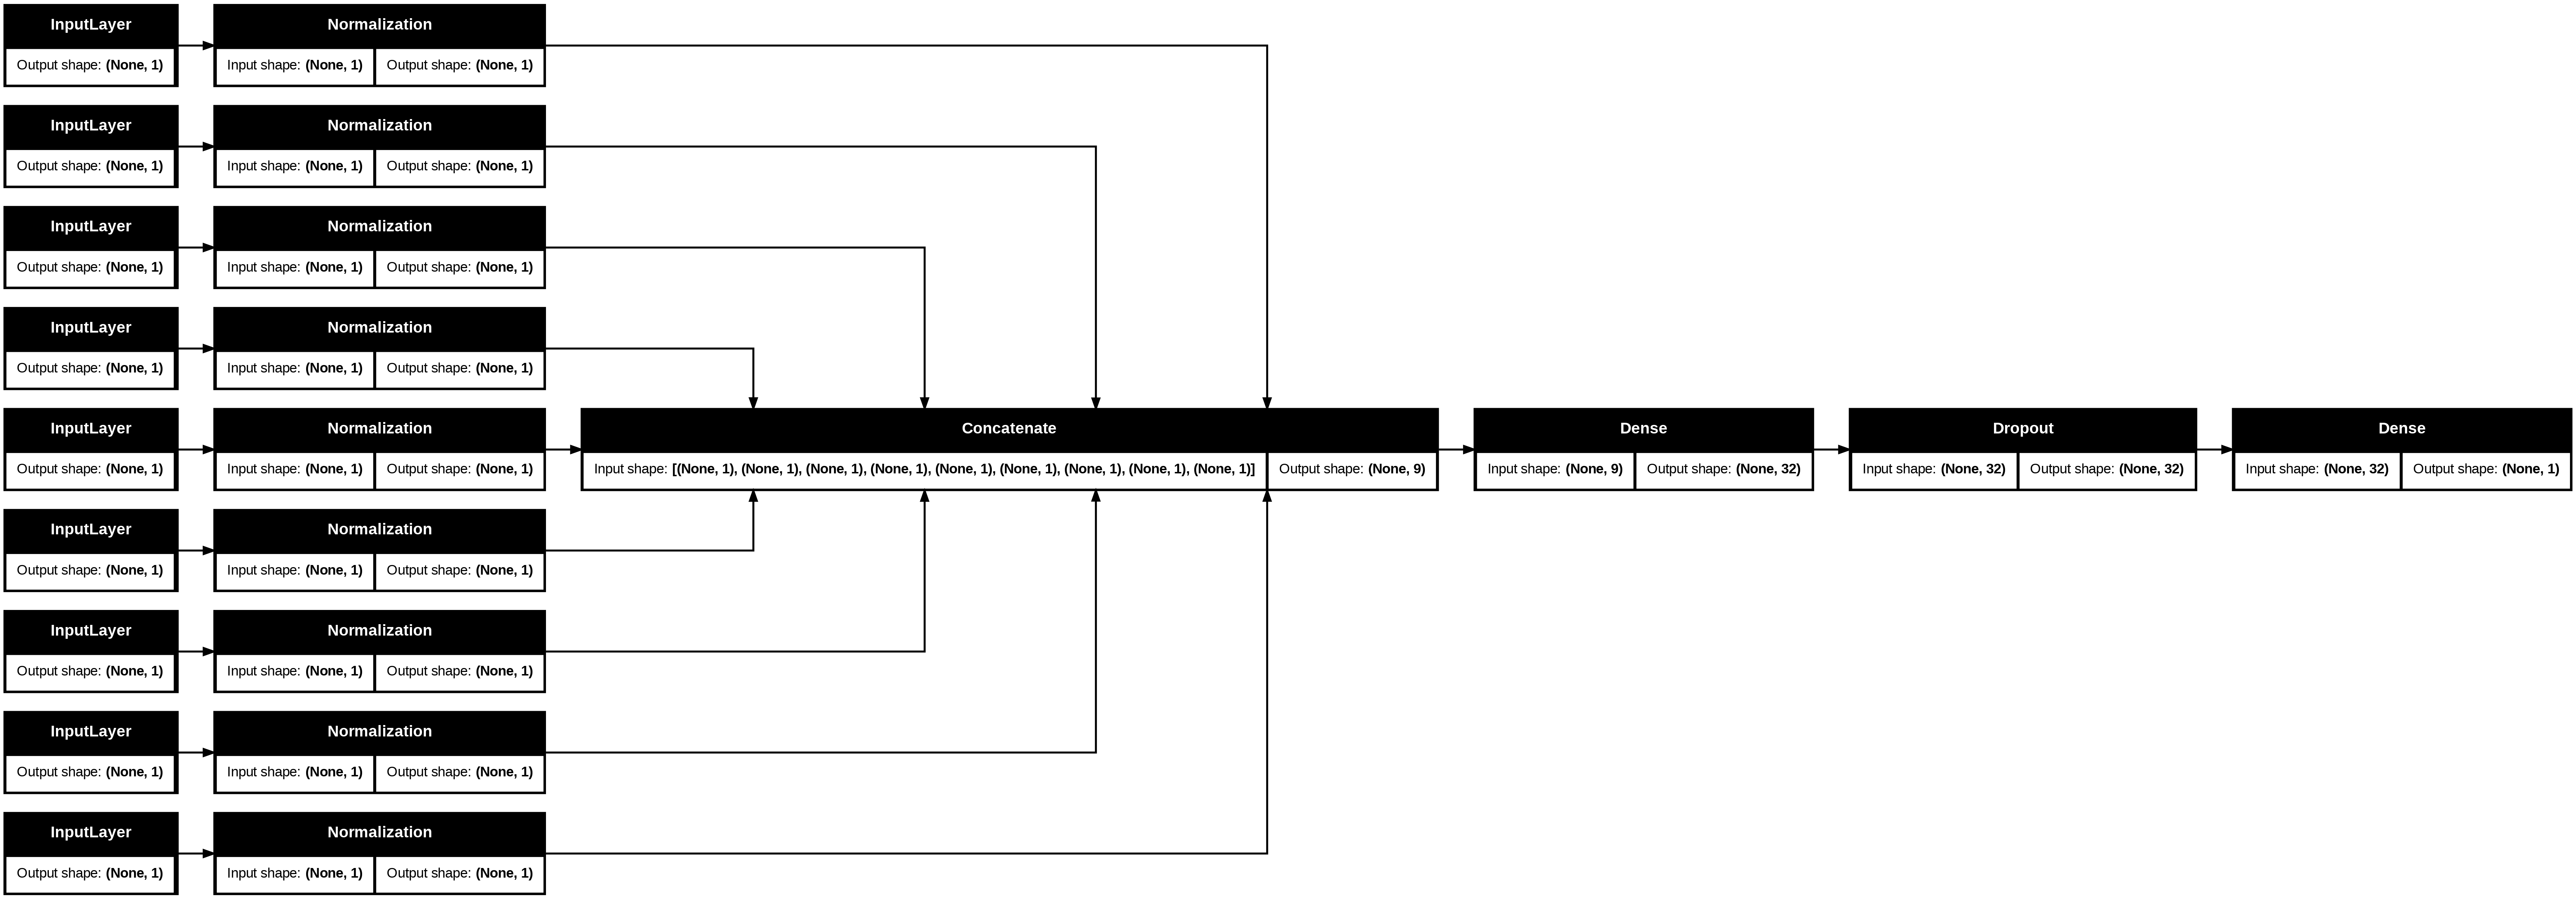

In [49]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
